# Определение возраста покупателей

<b> Описание проекта </b>

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

  - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

  - Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image

Загрузим имеющийся датасет, посмотрим на размер выборки.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.shape

(7591, 2)

In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Построим график распределения возраста в выборке.

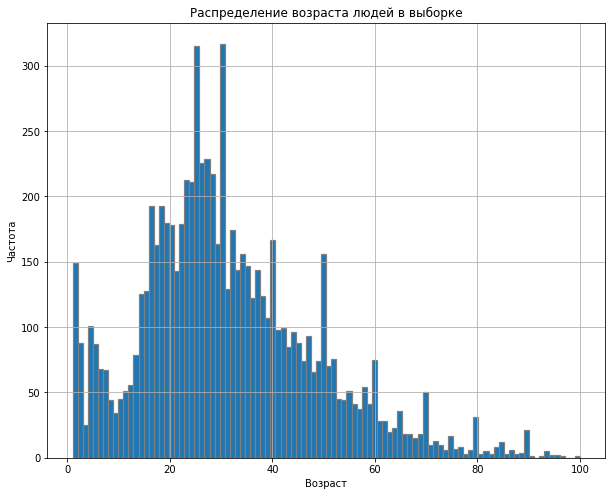

In [6]:
plt.figure(figsize=(10,8))
plt.hist(labels['real_age'], bins=100, edgecolor='grey', linewidth=1.2)
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.grid()
plt.title('Распределение возраста людей в выборке')
plt.show()

Судя по распределению возраст большинства людей в выборке находится в диапазоне от 18 до 40 лет. Присутствуют "пики" в 20, 30, 40, 50 и т.д. лет, это можно связать с тем, что при ручной разметке базы возраст некоторых людей не был доподлинно известен, поэтому был округлен до ближайшего предполагаемого.

Напечатаем первые 15 фотографий.

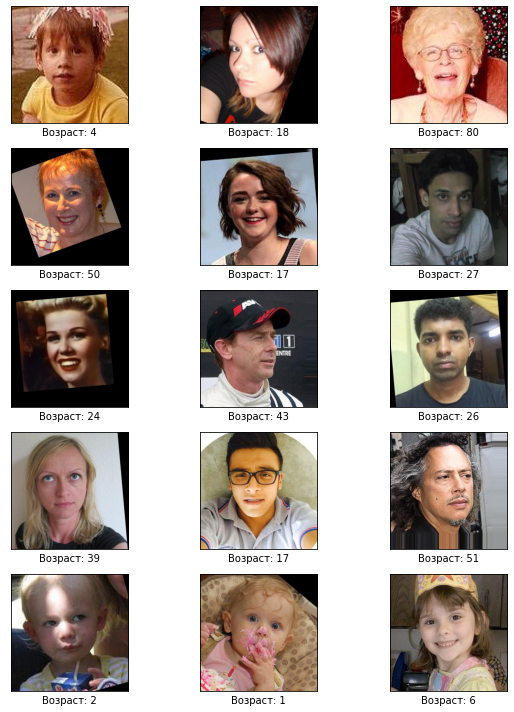

In [7]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(5, 3, i+1)
    image =Image.open('/datasets/faces/final_files/'+labels['file_name'][i])
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.xlabel(f"Возраст: {labels['real_age'][i]}")


Первые 15 фото, содержащиеся в выборке, дают возможность представить, с какими данными будет работать будущая модель. 

Выделим следующие особенности и закономерности:

 - На фото люди сняты с разных ракурсов (лежа, сидя, повернув голову набок и т.д.)
 - Присутствуют аксессуары и посторонные предметы, частично закрывающие часть лица или головы (очки, головные уборы, украшения)
 - На некоторых фото присутствуют черная рамка вокруг (видимо, это фотографии были меньше необходимого размера)
 - Присутствует различный фон на фотографиях, что увеличивает уровень визуального шума
 
Все эти особенности делают задачу корректного определения возраста человека по фото сложнее.
Что, в свою очередь, может стать дополнительным фактором недостаточности данных для достижения целевой метрики работы модели, дополнительным стимулом к использованию аугментации с целью увеличения обучающей выборки при моделировании.


<b> Вывод: </b> В нашем распоряжении набор данных, состоящий из 7591 фотографий людей разных возрастов. Большая часть людей на фото имеет возраст от 18 до 40 лет. Скорее всего база была размечена вручную, что обуславливает "всплески" количества людей в юбилейные годы. 

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    datagen = ImageDataGenerator(validation_split=0.2,
                                 vertical_flip=True,
                                 horizontal_flip=True,
                                 rotation_range=15,
                                 rescale=1/255.)
 
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+'labels.csv'),
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224,224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_datagen_flow 

def load_test(path):
    datagen = ImageDataGenerator(validation_split=0.2,
                                 horizontal_flip=True,
                                 rescale=1/255.)
 
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+'labels.csv'),
        directory= path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224,224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)   
    
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=(224,224,3),
                      weights='imagenet',
                      include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, 
                  loss='mse',
                  metrics=['mae'])
 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch=len(train_data)
    if validation_steps is None:
        validation_steps=len(test_data)
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model

```

<b> Вывод: </b>

Found 6073 validated image filenames.

Found 1518 validated image filenames.

Train for 190 steps, validate for 48 steps

190/190 - 120s - loss: 238.5010 - mae: 11.2921 - val_loss: 623.5179 - val_mae: 19.8552

Epoch 2/5
190/190 - 98s - loss: 110.1046 - mae: 7.9500 - val_loss: 691.4717 - val_mae: 21.1275

Epoch 3/5
190/190 - 93s - loss: 90.3541 - mae: 7.1670 - val_loss: 273.9490 - val_mae: 12.0296

Epoch 4/5
190/190 - 95s - loss: 79.0567 - mae: 6.8035 - val_loss: 133.1927 - val_mae: 8.6003

Epoch 5/5
190/190 - 94s - loss: 65.3060 - mae: 6.1940 - val_loss: 88.1091 - val_mae: 7.0562
48/48 - 8s - loss: 88.3342 - mae: 7.0302

Test MAE: 7.0302


## Анализ обученной модели

Целью проекта было построить модель, которая сможет по фото определять возраст человека.

Удалось построить модель с использованием ResNet50. Для достижения адекватной поставленной задаче целевой метрики (MAE) была применена аугментация, так как выборка недостаточно большая для корректного определения возраста с высокой точностью. Разброс возрастов в выборке достаточно высокий, присутствуют фото с частично закрытыми частями лица (головные уборы, аксессуары, постронние предметы).

Обучение модели происходило за 5 эпох, удалось снизить метрику MAE c 19.85 до 7.

В итоговой модели удалось достичь показателя среднеарифметической ошибки равной 7, то есть в среднем модель сможет определить возраст покупателя отклоняясь от реальной цифры примерно на 7 лет. 

Это довольно неплохой результат, учитывая факт, что разделять покупателей на категории можно примерно в возрастном промежутке 10-15 лет. Модель адекватна поставленной задаче, ее можно тестировать в реальных условиях.


## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы